In [34]:
import os
import sys
import random
import pickle
import numpy as np
import pandas as pd
import scipy.io as scio
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

In [35]:
def seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)

seed = 42
seed_all(seed)

In [36]:
# 输入特征的读取
feature_path = "AWA2/split/res101.mat"
feature_data = scio.loadmat(feature_path)
features = feature_data['features'].transpose(1,0)
labels = feature_data['labels'].reshape(-1)

# {类label:类名}字典读取
classes_path = 'AWA2/classes.txt'
# key is label name, value is label id
class_dict = pd.read_csv(classes_path, sep='\t', header=None).set_index(1)[0].to_dict()

# 训练/验证类label读取
trainval_classes_path = 'AWA2/split/trainvalclasses.txt'
trainval_names = pd.read_csv(trainval_classes_path, header=None)[0].to_list()
trainval_values = [class_dict[name] for name in trainval_names]

# 测试类label读取
test_classes_path = 'AWA2/split/testclasses.txt'
test_names = pd.read_csv(test_classes_path, header=None)[0].to_list()
test_values = [class_dict[name] for name in test_names]

# 训练集与测试集features划分
trainval_indices, test_indices = [], []
for idx, label in enumerate(labels):
    if label in trainval_values:
        trainval_indices.append(idx)
    else:
        test_indices.append(idx)
trainval_features = features[trainval_indices]
test_features = features[test_indices]
trainval_labels = labels[trainval_indices]
test_labels = labels[test_indices]
trainval_features = np.array(trainval_features)
test_features = np.array(test_features)
trainval_labels = np.array(trainval_labels)
test_labels = np.array(test_labels)

In [37]:
# 计算相似度矩阵，对称矩阵，所以取(i,j)还是(j,i)无所谓
attribute_path = "AWA2/split/att_splits.mat"
attribute_data = scio.loadmat(attribute_path)
attributes = attribute_data['att'].transpose(1,0)
similarity_matrix = cosine_similarity(attributes)
# similarity_matrix = 1 / euclidean_distances(attributes)

In [38]:
# 为所有seen category训练一个binary classifier
model_list = []
for name in trainval_names:
    print(f'train {name} category classifier')
    # 首先将标签变为0、1标签
    positive_label = class_dict[name]
    binary_trainval_labels = [1 if label==positive_label else 0 for label in trainval_labels]
    binary_trainval_labels = np.array(binary_trainval_labels)

    # 定义binary classifier并训练
    binary_model = LogisticRegression(max_iter=10000)
    binary_model.fit(trainval_features, binary_trainval_labels)
    with open(os.path.join('models_2', name+'.pickle'), 'wb') as f:
        pickle.dump(binary_model, f)
    # predictions = binary_model.predict(trainval_features)
    # print("len:", len(binary_trainval_labels),"acc count:", (binary_trainval_labels==predictions).sum())
    model_list.append(binary_model)

train killer+whale category classifier
train beaver category classifier
train dalmatian category classifier
train persian+cat category classifier
train german+shepherd category classifier
train siamese+cat category classifier
train skunk category classifier
train mole category classifier
train tiger category classifier
train hippopotamus category classifier
train leopard category classifier
train spider+monkey category classifier
train elephant category classifier
train gorilla category classifier
train ox category classifier
train chimpanzee category classifier
train hamster category classifier
train fox category classifier
train squirrel category classifier
train rabbit category classifier
train wolf category classifier
train chihuahua category classifier
train weasel category classifier
train otter category classifier
train buffalo category classifier
train zebra category classifier
train giant+panda category classifier
train pig category classifier
train lion category classifier
tr

In [39]:
# 计算seen category的binary classifier的结果
shape = len(test_labels)
seen_pred_dict = {}
for value, model in zip(trainval_values, model_list):
    predictions = model.predict(test_features)
    seen_pred_dict[value] = predictions
seen_pred_dict = dict(sorted(seen_pred_dict.items()))

# 根据权重计算unseen category的binary classifier结果
pred_list = []
for test_value in test_values:
    pred_sum = np.zeros(shape)
    for trainval_value in seen_pred_dict.keys():
        pred_sum += similarity_matrix[test_value-1][trainval_value-1] * seen_pred_dict[trainval_value]
    pred_list.append(pred_sum)
pred_list = np.array(pred_list)

result_indices = np.argmax(pred_list, axis=0)
results = [test_values[index] for index in result_indices]

In [40]:
# 计算seen category的binary classifier的结果
shape = len(test_labels)
seen_pred_dict = {}
for value, model in zip(trainval_values, model_list):
    predictions = model.predict(test_features)
    seen_pred_dict[value] = predictions
# 根据权重计算unseen category的binary classifier结果
pred_list = []
for test_value in test_values:
    pred_sum = np.zeros(shape)
    similarity_vector = similarity_matrix[test_value-1][np.array(list(seen_pred_dict.keys()))-1]
    normalized_weight = similarity_vector / np.linalg.norm(similarity_vector)
    for idx, trainval_value in enumerate(seen_pred_dict.keys()):
        pred_sum += normalized_weight[idx] * seen_pred_dict[trainval_value]
    # for trainval_value in seen_pred_dict.keys():
    #     pred_sum += similarity_matrix[test_value-1][trainval_value-1] * seen_pred_dict[trainval_value]
    # pred_list.append(pred_sum)
pred_list = np.array(pred_list)

result_indices = np.argmax(pred_list, axis=0)
results = [test_values[index] for index in result_indices]

ValueError: attempt to get argmax of an empty sequence

acc count: 2444
acc count: 7913
acc: {23: 973, 50: 0, 30: 0, 24: 280, 9: 170, 34: 166, 7: 739, 47: 11, 31: 2, 41: 103}
test: {23: 1420, 50: 946, 30: 383, 24: 988, 9: 174, 34: 310, 7: 1645, 47: 215, 31: 1202, 41: 630}


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'sheep'),
  Text(1, 0, 'dolphin'),
  Text(2, 0, 'bat'),
  Text(3, 0, 'seal'),
  Text(4, 0, 'blue+whale'),
  Text(5, 0, 'rat'),
  Text(6, 0, 'horse'),
  Text(7, 0, 'walrus'),
  Text(8, 0, 'giraffe'),
  Text(9, 0, 'bobcat')])

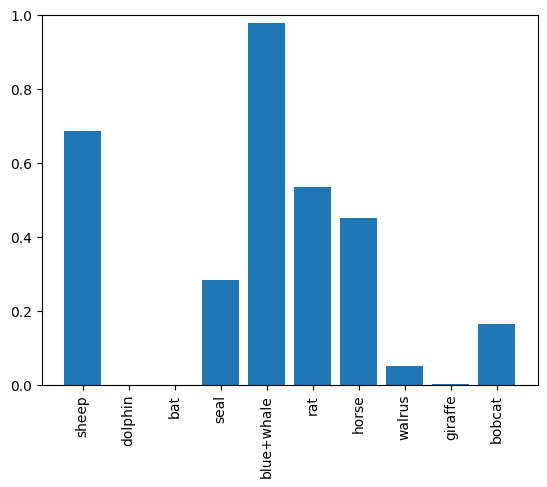

In [ ]:
print("acc count:", (results==test_labels).sum())
print("acc count:", len(test_labels))
acc_dict, test_dict = {}, {}
for test_value in test_values:
    acc_dict[test_value] = test_dict[test_value] = 0
for pred, value in zip(results, test_labels):
    test_dict[value] += 1
    if pred == value:
        acc_dict[value] += 1

print("acc:", acc_dict)
print("test:", test_dict)

rate = []
acc_count = 0
for value in test_values:
    rate.append(acc_dict[value]/test_dict[value])
    acc_count += acc_dict[value]
canvas = plt.figure()
plt.cla()
plt.bar(test_names, rate)
plt.ylim(0,1)
plt.xticks(rotation=90)

